# **Finetuning TimesFM 2.0 with Pre- and Post-Finetune Evaluation**

This notebook demonstrates how to:
1. Install dependencies.
2. Set up a finetuning framework for [TimesFM](https://github.com/google-research/google-research/tree/master/times_fm) in PyTorch.
3. Download stock data (AAPL) from [yfinance](https://pypi.org/project/yfinance/) and create train/val datasets.
4. Generate predictions **before** fine-tuning and plot them.
5. Fine-tune the model for a few epochs.
6. Generate predictions **after** fine-tuning and plot them.
7. Save both sets of predictions.
8. Compare the difference visually in one plot.
9. **Save the fine-tuned model locally** in a `.ckpt` file to `./model/fine_tuned_model.ckpt`.

## **1. Install Dependencies**
Uncomment and run the cell below if you need to install packages into your environment.

In [ ]:
%%capture  
!pip install torch
!pip install yfinance
!pip install wandb
!pip install huggingface_hub
!pip install timesfm[torch]  # For timesfm version >= 1.2.6


## **2. Imports & Basic Setup**

In [1]:
import os
import logging
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP

import yfinance as yf
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download

# TimesFM imports
from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder

# If you want to log with wandb, import wandb (optional)
import wandb

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


In [2]:
import os 

os.environ['WANDB_API_KEY'] = '8489739d838b89d2f424147f354f9db40517c1c9'
os.environ["WANDB_NOTEBOOK_NAME"] = "/home/jupyter/TimesFM-Examples/src/tune/03-finetune.ipynb"

wandb.init(project="TimesFM-Examples")

wandb: Currently logged in as: shankar-arunp. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## **3. Finetuning Framework**
Below is a flexible framework for training/finetuning a TimesFM model on custom time series data.

In [3]:
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Any, Callable, Dict, List, Optional, Tuple

class MetricsLogger(ABC):
    """Abstract base class for logging metrics during training."""
    @abstractmethod
    def log_metrics(self, metrics: Dict[str, Any], step: Optional[int] = None) -> None:
        pass

    @abstractmethod
    def close(self) -> None:
        pass

class WandBLogger(MetricsLogger):
    """Weights & Biases implementation of metrics logging."""
    def __init__(self, project: str, config: Dict[str, Any], rank: int = 0):
        self.rank = rank
        if rank == 0:
            wandb.init(project=project, config=config)

    def log_metrics(self, metrics: Dict[str, Any], step: Optional[int] = None) -> None:
        if self.rank == 0:
            wandb.log(metrics, step=step)

    def close(self) -> None:
        if self.rank == 0:
            wandb.finish()

class DistributedManager:
    """Manages distributed training setup and cleanup."""
    def __init__(
        self,
        world_size: int,
        rank: int,
        master_addr: str = "localhost",
        master_port: str = "12358",
        backend: str = "nccl",
    ):
        self.world_size = world_size
        self.rank = rank
        self.master_addr = master_addr
        self.master_port = master_port
        self.backend = backend

    def setup(self) -> None:
        os.environ["MASTER_ADDR"] = self.master_addr
        os.environ["MASTER_PORT"] = self.master_port
        if not dist.is_initialized():
            dist.init_process_group(
                backend=self.backend, world_size=self.world_size, rank=self.rank
            )

    def cleanup(self) -> None:
        if dist.is_initialized():
            dist.destroy_process_group()

@dataclass
class FinetuningConfig:
    """Configuration for model training."""
    batch_size: int = 32
    num_epochs: int = 20
    learning_rate: float = 1e-4
    weight_decay: float = 0.01
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    distributed: bool = False
    gpu_ids: List[int] = field(default_factory=lambda: [0])
    master_port: str = "12358"
    master_addr: str = "localhost"
    use_wandb: bool = False
    wandb_project: str = "timesfm-finetuning"

class TimesFMFinetuner:
    """Handles model training and validation for TimesFM."""
    def __init__(
        self,
        model: nn.Module,
        config: FinetuningConfig,
        rank: int = 0,
        loss_fn: Optional[Callable] = None,
        logger: Optional[logging.Logger] = None,
    ):
        self.model = model
        self.config = config
        self.rank = rank
        self.logger = logger or logging.getLogger(__name__)
        self.device = torch.device(
            f"cuda:{rank}" if torch.cuda.is_available() else "cpu"
        )
        self.loss_fn = loss_fn or (lambda x, y: torch.mean((x - y.squeeze(-1)) ** 2))

        if config.use_wandb:
            self.metrics_logger = WandBLogger(config.wandb_project, config.__dict__, rank)
        else:
            self.metrics_logger = None

        if config.distributed:
            self.dist_manager = DistributedManager(
                world_size=len(config.gpu_ids),
                rank=rank,
                master_addr=config.master_addr,
                master_port=config.master_port,
            )
            self.dist_manager.setup()
            self.model = self._setup_distributed_model()
        else:
            self.model = self.model.to(self.device)

    def _setup_distributed_model(self) -> nn.Module:
        self.model = self.model.to(self.device)
        return DDP(
            self.model,
            device_ids=[self.config.gpu_ids[self.rank]],
            output_device=self.config.gpu_ids[self.rank]
        )

    def _create_dataloader(self, dataset: Dataset, is_train: bool) -> DataLoader:
        if self.config.distributed:
            sampler = torch.utils.data.distributed.DistributedSampler(
                dataset,
                num_replicas=len(self.config.gpu_ids),
                rank=dist.get_rank(),
                shuffle=is_train
            )
        else:
            sampler = None

        return DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=(is_train and not self.config.distributed),
            sampler=sampler,
        )

    def _process_batch(self, batch: List[torch.Tensor]) -> tuple:
        # batch = [x_context, x_padding, freq, x_future]
        x_context, x_padding, freq, x_future = [
            t.to(self.device, non_blocking=True) for t in batch
        ]

        predictions = self.model(x_context, x_padding.float(), freq)
        predictions_mean = predictions[..., 0]
        last_patch_pred = predictions_mean[:, -1, :]
        loss = self.loss_fn(last_patch_pred, x_future.squeeze(-1))

        return loss, predictions

    def _train_epoch(self, train_loader: DataLoader, optimizer: torch.optim.Optimizer) -> float:
        self.model.train()
        total_loss = 0.0

        for batch in train_loader:
            loss, _ = self._process_batch(batch)

            if self.config.distributed:
                # Gather losses across replicas for consistent logging
                losses = [torch.zeros_like(loss) for _ in range(dist.get_world_size())]
                dist.all_gather(losses, loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def _validate(self, val_loader: DataLoader) -> float:
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                loss, _ = self._process_batch(batch)
                if self.config.distributed:
                    losses = [torch.zeros_like(loss) for _ in range(dist.get_world_size())]
                    dist.all_gather(losses, loss)
                total_loss += loss.item()

        return total_loss / len(val_loader)

    def finetune(self, train_dataset: Dataset, val_dataset: Dataset) -> Dict[str, Any]:
        # Moved model.to(self.device) to __init__ for non-distributed mode
        train_loader = self._create_dataloader(train_dataset, is_train=True)
        val_loader = self._create_dataloader(val_dataset, is_train=False)

        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )

        history = {"train_loss": [], "val_loss": [], "learning_rate": []}

        self.logger.info(f"Starting training for {self.config.num_epochs} epochs...")
        self.logger.info(f"Training samples: {len(train_dataset)}")
        self.logger.info(f"Validation samples: {len(val_dataset)}")

        try:
            for epoch in range(self.config.num_epochs):
                train_loss = self._train_epoch(train_loader, optimizer)
                val_loss = self._validate(val_loader)
                current_lr = optimizer.param_groups[0]["lr"]

                metrics = {
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "learning_rate": current_lr,
                    "epoch": epoch + 1,
                }

                if self.metrics_logger is not None:
                    self.metrics_logger.log_metrics(metrics)

                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["learning_rate"].append(current_lr)

                if self.rank == 0:
                    self.logger.info(
                        f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
                    )
        except KeyboardInterrupt:
            self.logger.info("Training interrupted by user")

        if self.config.distributed:
            self.dist_manager.cleanup()

        if self.metrics_logger is not None:
            self.metrics_logger.close()

        return {"history": history}


## **4. Dataset Preparation**
A sliding-window time-series dataset, plus a helper to split into train/val sets.

In [4]:
class TimeSeriesDataset(Dataset):
    """Dataset for time series data compatible with TimesFM."""
    def __init__(self, series: np.ndarray, context_length: int, horizon_length: int):
        self.series = series
        self.context_length = context_length
        self.horizon_length = horizon_length
        self._prepare_samples()

    def _prepare_samples(self) -> None:
        self.samples = []
        total_length = self.context_length + self.horizon_length
        for start_idx in range(0, len(self.series) - total_length + 1):
            end_idx = start_idx + self.context_length
            x_context = self.series[start_idx:end_idx]
            x_future = self.series[end_idx : end_idx + self.horizon_length]
            self.samples.append((x_context, x_future))

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        x_context, x_future = self.samples[index]
        x_context = torch.tensor(x_context, dtype=torch.float32)
        x_future = torch.tensor(x_future, dtype=torch.float32)

        # TimesFM expects certain input shapes:
        input_padding = torch.zeros_like(x_context)
        freq = torch.zeros(1, dtype=torch.long)  # Dummy freq

        return x_context, input_padding, freq, x_future

def prepare_datasets(
    series: np.ndarray,
    context_length: int,
    horizon_length: int,
    train_split: float = 0.8
) -> Tuple[Dataset, Dataset]:
    train_size = int(len(series) * train_split)
    train_data = series[:train_size]
    val_data = series[train_size:]

    train_dataset = TimeSeriesDataset(train_data, context_length, horizon_length)
    val_dataset = TimeSeriesDataset(val_data, context_length, horizon_length)
    return train_dataset, val_dataset


## **5. Model Creation**
A helper function that loads the official TimesFM checkpoint from Hugging Face. Set `load_weights=True` to load model weights.

In [5]:
from os import path

def get_model(load_weights: bool = True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    repo_id = "google/timesfm-2.0-500m-pytorch"
    hparams = TimesFmHparams(
        backend=device,
        per_core_batch_size=32,
        horizon_len=128,       # Example horizon
        num_layers=50,
        use_positional_embedding=False,
        context_len=192,      # Example context
    )
    tfm = TimesFm(hparams=hparams, checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))
    model = PatchedTimeSeriesDecoder(tfm._model_config)

    if load_weights:
        checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
        loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(loaded_checkpoint)
    return model, hparams, tfm._model_config


## **6. Plotting & Helper Utilities**
- **`get_predictions_from_sample`**: Return predicted future values for a single sample.
- **`plot_pre_and_post_predictions`**: Combine pre- vs. post-finetune predictions in one plot.
- **`get_data`**: Downloads AAPL stock data via `yfinance`, then prepares train/val datasets.

In [6]:
def get_predictions_from_sample(
    model: nn.Module,
    sample: tuple,
    device: torch.device = torch.device("cpu")
) -> np.ndarray:
    """
    Given a single sample (x_context, x_padding, freq, x_future),
    return the predicted future values as a numpy array.
    """
    model.eval()
    x_context, x_padding, freq, _ = sample

    # Expand dims to batch=1, then move to device
    x_context = x_context.unsqueeze(0).to(device)
    x_padding = x_padding.unsqueeze(0).float().to(device)
    freq = freq.unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(x_context, x_padding, freq)
        # predictions shape: [B, N, horizon_len, 3] or [B, N, horizon_len]
        predictions_mean = predictions[..., 0]  # [B, N, horizon_len]
        last_patch_pred = predictions_mean[:, -1, :]  # [B, horizon_len]

    return last_patch_pred[0].cpu().numpy()

def plot_pre_and_post_predictions(
    context_vals: np.ndarray,
    future_vals: np.ndarray,
    pre_preds: np.ndarray,
    post_preds: np.ndarray,
    save_path: str = "compare_predictions.png"
):
    """
    Compare pre-finetuning vs. post-finetuning predictions in one plot.
    """
    plt.figure(figsize=(10, 6))

    context_len = len(context_vals)
    horizon_len = len(future_vals)

    # Plot historical context
    plt.plot(
        range(context_len), context_vals,
        label="Historical Context",
        color="black",
        linewidth=2
    )

    # Plot ground truth future
    plt.plot(
        range(context_len, context_len + horizon_len),
        future_vals,
        label="Ground Truth Future",
        color="green",
        linestyle="--",
        linewidth=2
    )

    # Pre-finetune predictions
    plt.plot(
        range(context_len, context_len + horizon_len),
        pre_preds,
        label="Pre-Finetune Prediction",
        color="red",
        linewidth=2
    )

    # Post-finetune predictions
    plt.plot(
        range(context_len, context_len + horizon_len),
        post_preds,
        label="Post-Finetune Prediction",
        color="blue",
        linewidth=2
    )

    plt.title("Pre-Finetuning vs. Post-Finetuning Predictions")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

    plt.savefig(save_path, dpi=120)
    print(f"Comparison plot saved to {save_path}")
    plt.show()

def get_data(context_len: int, horizon_len: int) -> Tuple[Dataset, Dataset]:
    """
    Download AAPL stock data from yfinance, then create train/val datasets.
    """
    df = yf.download("AAPL", start="2010-01-01", end="2019-01-01")
    time_series = df["Close"].values
    train_dataset, val_dataset = prepare_datasets(
        series=time_series,
        context_length=context_len,
        horizon_length=horizon_len,
        train_split=0.8,
    )
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    return train_dataset, val_dataset


## **7. Single-GPU Finetuning Example**
We combine everything into a single function:
1. Load the model **with** pre-trained weights.
2. Get a single sample from `val_dataset` to test predictions.
3. Plot & save **pre-finetune** predictions.
4. Fine-tune for a few epochs.
5. Plot & save **post-finetune** predictions.
6. Compare them in one combined plot.
7. **Save the fine-tuned model** as a `.ckpt` file to `./model/fine_tuned_model.ckpt`.

In [7]:
import logging
from pathlib import Path

def single_gpu_example():
    # 1) Create model & load checkpoint
    model, hparams, tfm_config = get_model(load_weights=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 2) Finetuning config
    config = FinetuningConfig(
        batch_size=256,
        num_epochs=5,
        learning_rate=1e-4,
        use_wandb=False,  # set True if you want to log metrics
        wandb_project="timesfm-finetuning"
    )

    # 3) Prepare data
    train_dataset, val_dataset = get_data(
        context_len=128,
        horizon_len=tfm_config.horizon_len
    )

    # Pick one sample from val_dataset to illustrate pre- vs. post-
    sample_idx = 0
    sample = val_dataset[sample_idx]
    x_context, _, _, x_future = sample
    context_vals = x_context.numpy()
    future_vals = x_future.numpy()

    # 4) Pre-finetune predictions
    pre_preds = get_predictions_from_sample(model, sample, device)
    np.save("pre_finetune_predictions.npy", pre_preds)
    print("Pre-finetune predictions saved to pre_finetune_predictions.npy")

    # Quick single-plot of pre-finetune
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(context_vals)), context_vals, label="Context", color="black")
    plt.plot(
        range(len(context_vals), len(context_vals)+len(future_vals)),
        future_vals,
        label="Ground Truth",
        color="green",
        linestyle="--"
    )
    plt.plot(
        range(len(context_vals), len(context_vals)+len(pre_preds)),
        pre_preds,
        label="Pre-Finetune Preds",
        color="red"
    )
    plt.title("Pre-Finetune Prediction")
    plt.legend()
    plt.grid(True)
    plt.savefig("pre_finetune_plot.png", dpi=120)
    plt.show()

    # 5) Finetuner and train
    logger = logging.getLogger("TimesFMFinetuner")
    logging.basicConfig(level=logging.INFO)
    finetuner = TimesFMFinetuner(model, config, logger=logger)

    print("\nStarting finetuning...")
    results = finetuner.finetune(train_dataset=train_dataset, val_dataset=val_dataset)
    print("Finetuning completed!")

    # 6) Post-finetune predictions
    post_preds = get_predictions_from_sample(model, sample, device)
    np.save("post_finetune_predictions.npy", post_preds)
    print("Post-finetune predictions saved to post_finetune_predictions.npy")

    # Quick single-plot of post-finetune
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(context_vals)), context_vals, label="Context", color="black")
    plt.plot(
        range(len(context_vals), len(context_vals)+len(future_vals)),
        future_vals,
        label="Ground Truth",
        color="green",
        linestyle="--"
    )
    plt.plot(
        range(len(context_vals), len(context_vals)+len(post_preds)),
        post_preds,
        label="Post-Finetune Preds",
        color="blue"
    )
    plt.title("Post-Finetune Prediction")
    plt.legend()
    plt.grid(True)
    plt.savefig("post_finetune_plot.png", dpi=120)
    plt.show()

    # 7) Compare pre vs. post in one figure
    plot_pre_and_post_predictions(
        context_vals=context_vals,
        future_vals=future_vals,
        pre_preds=pre_preds,
        post_preds=post_preds,
        save_path="compare_pre_post_finetune.png"
    )

    # 8) Save the fine-tuned model as .ckpt
    Path("./model").mkdir(exist_ok=True)
    torch.save(model.state_dict(), "./model/fine_tuned_model.ckpt")
    print("Fine-tuned model weights saved to ./model/fine_tuned_model.ckpt")

    # 9) Print final training history
    train_hist = results["history"]["train_loss"]
    val_hist = results["history"]["val_loss"]
    for epoch_i, (tr_loss, vl_loss) in enumerate(zip(train_hist, val_hist)):
        print(f"Epoch {epoch_i+1} => Train Loss: {tr_loss:.4f}, Val Loss: {vl_loss:.4f}")

    print("\nDone!")

## **8. Execute the Example**
Run the cell below to:
1. Download TimesFM (2GB checkpoint) if not already cached.
2. Download AAPL data.
3. Evaluate/plot pre- and post-finetune predictions.
4. Save everything, including the final `.ckpt` model file.

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


Training samples: 1556
Validation samples: 198
Pre-finetune predictions saved to pre_finetune_predictions.npy


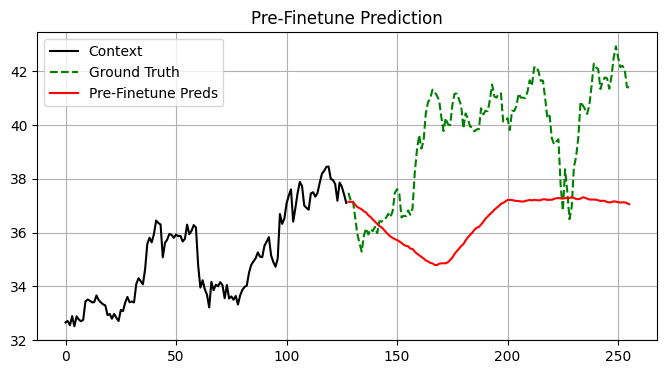


Starting finetuning...
Finetuning completed!
Post-finetune predictions saved to post_finetune_predictions.npy


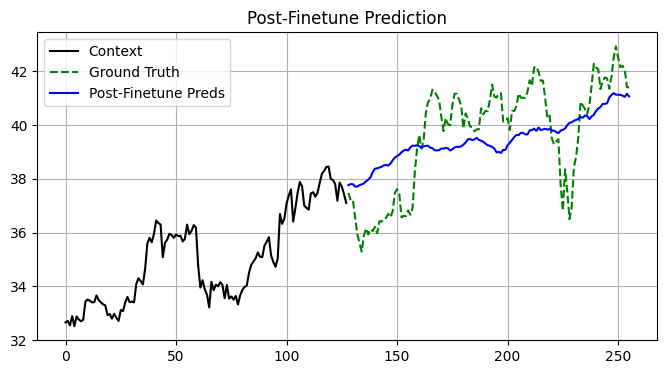

Comparison plot saved to compare_pre_post_finetune.png


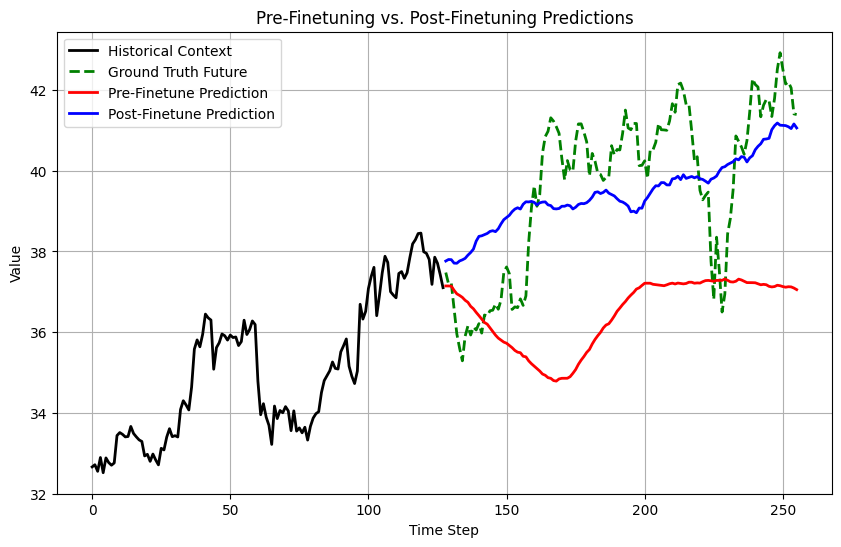

Fine-tuned model weights saved to ./model/fine_tuned_model.ckpt
Epoch 1 => Train Loss: 5.4481, Val Loss: 16.3403
Epoch 2 => Train Loss: 2.4664, Val Loss: 25.1334
Epoch 3 => Train Loss: 1.0429, Val Loss: 24.9551
Epoch 4 => Train Loss: 0.7683, Val Loss: 32.2276
Epoch 5 => Train Loss: 0.6631, Val Loss: 16.3665

Done!


In [8]:
# Run the entire pipeline.
single_gpu_example()